In [1]:
import os

import matplotlib.pyplot as plt
import nibabel

from tqdm import tqdm
import numpy as np
from data_preparation.utils import  resize_data_volume
from scipy import ndimage
from scipy.interpolate import interpn
from pytorch.build_model import BuildSTN
from torch import nn
import torch.nn.functional as F
import torch


In [168]:
class SpatialTransformer(nn.Module):

    def __init__(self, dim, mode='nearest'):
        """
        Instiatiate the block
            :param input_shape: size of input to the spatial transformer block (h,w,d)
            :param mode: method of interpolation for grid_sampler
        """
        super(SpatialTransformer, self).__init__()
        self.dim = dim
        self.mode = mode

    def forward(self, src, flow):
        """
        Push the src and flow through the spatial transform block
            :param src: the original aligned_liver image
            :param flow: the exp_output from the U-Net
        """
        if self.dim == 3:
            batch, channel, height, width, slices = flow.size()
            size = [height, width, slices]
        else:
            batch, channel, height, width = flow.size()
            size = [height, width]
        # Create sampling grid
        vectors = [torch.arange(0, s) for s in size]
        grids = torch.meshgrid(vectors)
        grid = torch.stack(grids)  # y, x, z
        grid = torch.unsqueeze(grid, 0)  # add batch
        grid = grid.type(torch.FloatTensor)
        new_locs = grid + flow
        shape = flow.shape[2:]
        # Need to normalize grid values to [-1, 1] for resampler
        for i in range(len(shape)):
            new_locs[:, i, ...] = 2 * (new_locs[:, i, ...] / (shape[i] - 1) - 0.5)

        if len(shape) == 2:
            new_locs = new_locs.permute(0, 2, 3, 1)
            new_locs = new_locs[..., [1, 0]]
        elif len(shape) == 3:
            new_locs = new_locs.permute(0, 2, 3, 4, 1)
            new_locs = new_locs[..., [2, 1, 0]]
        print("new locs shape", new_locs.shape)

        return F.grid_sample(src, new_locs, align_corners =True, mode=self.mode)

In [169]:
def norm_z_score(image_A):
    mean_val = np.mean(image_A)
    std_val = np.std(image_A)

    rescale_slope = std_val + 1e-13
    rescale_intercept = mean_val

    image_A = (image_A - rescale_intercept) / rescale_slope
    return image_A, rescale_slope, rescale_intercept

In [178]:
# save dir
d_scan_path = 'HCC_1174/D/input/li_0000.nii'
d_mask_path = "HCC_1174/D/output/li.nii"
p_scan_path = 'HCC_1174/P/input/li_0000.nii'
p_mask_path = 'HCC_1174/P/output/li.nii'

# d part
d_scan = nibabel.load(d_scan_path)
d_scan_array = d_scan.get_fdata()
d_scan_array = np.flip(np.rot90(d_scan_array, axes = (0,1)), axis = 2)

# pre masks
d_mask_file = nibabel.load(d_mask_path)
d_mask_array = d_mask_file.get_fdata()
d_mask_array = np.flip(np.rot90(d_mask_array, axes = (0,1)), axis = 2)
# d_mask_array[d_mask_array == 2] = 1

# portal part
p_scan = nibabel.load(p_scan_path)
p_scan_array = p_scan.get_fdata()
p_scan_array = np.flip( np.rot90(p_scan_array, axes = (0,1)), axis = 2)

# portal masks
p_mask_file = nibabel.load(p_mask_path)
p_mask_array = p_mask_file.get_fdata()
p_mask_array = np.flip(np.rot90(p_mask_array, axes = (0,1)), axis = 2)
# p_mask_array[p_mask_array == 2] = 1

print('before resize delayed scan shape', d_scan_array.shape)
print('before resize portal scan shape', p_scan_array.shape)
print('before resize portal mask shape', p_mask_array.shape)

p_mask_val = p_scan_array * ndimage.binary_fill_holes(p_mask_array)
d_mask_val = d_scan_array * ndimage.binary_fill_holes(d_mask_array)

sf = 0.25  # shrink down 4 times
resized_d_scan = resize_data_volume(d_scan_array, [int(d_scan_array.shape[0] * sf), int(d_scan_array.shape[1] * sf), int(d_scan_array.shape[2] * sf)])
resized_p_scan = resize_data_volume(p_scan_array, [int(p_scan_array.shape[0] * sf), int(p_scan_array.shape[1] * sf), int(p_scan_array.shape[2] * sf)])
resized_d_mask = resize_data_volume(d_mask_val, [int(d_mask_val.shape[0] * sf), int(d_mask_val.shape[1] * sf), int(d_mask_val.shape[2] * sf)])
resized_p_mask = resize_data_volume(p_mask_val, [int(p_mask_val.shape[0] * sf), int(p_mask_val.shape[1] * sf), int(p_mask_val.shape[2] * sf)])

print('after resize d scan shape', resized_d_scan.shape)
print('after resize p scan shape', resized_p_scan.shape)
print('after resize d mask shape', resized_d_mask.shape)
print('after resize p mask shape', resized_p_mask.shape)


before resize delayed scan shape (512, 512, 103)
before resize portal scan shape (512, 512, 103)
before resize portal mask shape (512, 512, 103)
[0.25, 0.25, 0.24271844660194175]
[0.25, 0.25, 0.24271844660194175]
[0.25, 0.25, 0.24271844660194175]
[0.25, 0.25, 0.24271844660194175]
after resize d scan shape (128, 128, 25)
after resize p scan shape (128, 128, 25)
after resize d mask shape (128, 128, 25)
after resize p mask shape (128, 128, 25)


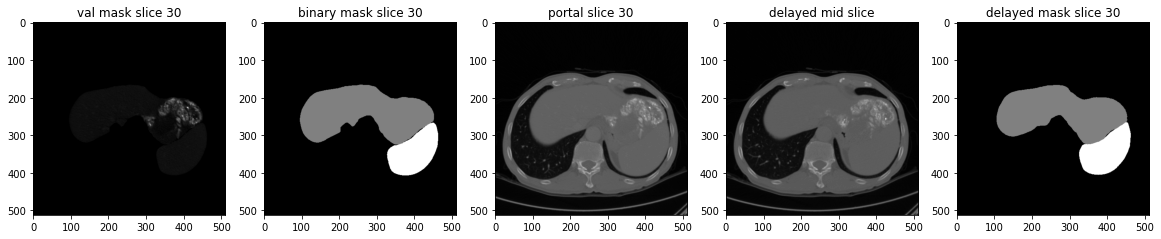

In [179]:
fig, (ax1, ax2, ax3, ax4, ax5) =plt.subplots(1,5, figsize = (20, 10))
ax1.set_title("val mask slice 30")
ax1.imshow(p_mask_val[:, :, 30], cmap='gray')
ax2.set_title("binary mask slice 30")
ax2.imshow(p_mask_array[:, :, 30], cmap='gray')
ax3.set_title("portal slice 30")
ax3.imshow(p_scan_array[:, :, 30], cmap='gray')
ax4.set_title('delayed mid slice')
ax4.imshow(d_scan_array[:, :, 30], cmap='gray')
ax5.set_title('delayed mask slice 30')
ax5.imshow(d_mask_array[:, :, 30], cmap='gray')

In [172]:
flow_root = '/media/monib/External Disk/work2022/voxelmorph_nets/voxelmorph_v02/scripts/flow_npy'
p_id = 'flow_HCC_1174_d.npy'
flow_pth = os.path.join(flow_root, p_id)

flow_np = np.load(flow_pth)[..., :103]
flow_np.shape

(3, 512, 512, 103)

In [173]:
def dice(vol1, vol2, labels = None, nargout = 1):
    """
    Dice [1] volume overlap metric
    The default is to *not* return a measure for the background layer (label = 0)
    [1] Dice, Lee R. "Measures of the amount of ecologic association between species."
    Ecology 26.3 (1945): 297-302.

    Parameters
    ---------------
    vol1 : nd array. The first volume (e.g. predicted volume)
    vol2 : nd array. The second volume (e.g. "true" volume)

    labels : optional vector of labels on which to compute Dice.
        If this is not provided, Dice is computed on all non-background (non-0) labels

    nargout : optional control of exp_output arguments. if 1, exp_output Dice measure(s).
        if 2, exp_output tuple of (Dice, labels)

    method : 'iter' (iterating through channels) or 'hist2' (using a histogram)

    Return
    ------
    if nargout == 1 : dice : vector of dice measures for each labels
    if nargout == 2 : (dice, labels) : where labels is a vector of the labels on which
        dice was computed
    """

    if labels is None:
        labels = np.unique(np.concatenate((vol1, vol2)))
        labels = np.delete(labels, np.where(labels == 0))  # remove background

    print('len of labels', len(labels))

    dicem = np.zeros(len(labels))
    for idx, lab in enumerate(labels):
        top = 2 * np.sum(np.logical_and(vol1 == lab, vol2 == lab))
        bottom = np.sum(vol1 == lab) + np.sum(vol2 == lab)
        bottom = np.maximum(bottom, np.finfo(float).eps)  # add epsilon.
        dicem[idx] = top / bottom

    if nargout == 1:
        return dicem
    else:
        return (dicem, labels)

In [186]:
def dice_loss (y_true, y_pred):
    ndims = len(list(y_pred.size())) - 2
    vol_axes = list(range(2, ndims + 2))
    top = 2 * (y_true * y_pred).sum(dim=vol_axes)
    bottom = torch.clamp((y_true + y_pred).sum(dim=vol_axes), min=1e-5)
    dice = torch.mean(top / bottom)

    return dice

In [188]:
# Dice as a metric (a.k.a, hard Dice)
y_true = d_mask_array.astype(np.float64)[np.newaxis, ...][np.newaxis, ...]
y_pred = p_mask_array.astype(np.float64)[np.newaxis, ...][np.newaxis, ...]

print('y_true shape', y_true.shape)

y_true = torch.from_numpy(y_true)
y_pred = torch.from_numpy(y_pred)
d_loss = dice_loss(y_true, y_pred)

# dice_score = dice(d_mask_array, d_mask_array)
print(d_loss)

y_true shape (1, 1, 512, 512, 103)
tensor(1.2948, dtype=torch.float64)


In [166]:
# Dice as a loss (a.k.a, soft dice)
dice_l = dice_loss(d_mask_array, d_mask_array)

TypeError: 'int' object is not callable

In [189]:
import torch

# n_d_mask, rs, ri = norm_z_score(d_mask_array)
# n_p_mask, rs_p, ri_p = norm_z_score(p_mask_val)
n_d_mask = d_mask_array.copy()[np.newaxis, ...][np.newaxis, ...]
p_d_mask = p_mask_array.copy()[np.newaxis, ...][np.newaxis, ...]
n_flow_np, _, _= norm_z_score(flow_np)

n_flow_np = n_flow_np[np.newaxis, ...]
# To torch
d_mask_torch = torch.from_numpy(n_d_mask)
p_mask_torch = torch.from_numpy(p_d_mask)
flow_torch = torch.from_numpy(n_flow_np)

print(f"Normed min: {np.min(n_d_mask)}, max: {np.max(n_d_mask)}")
print(f"Normed flow min: {np.min(n_flow_np)}, max: {np.max(n_flow_np)}")

print(f" Torch mask shape: {d_mask_torch.shape}, flow shape: {flow_torch.shape}")

# moved masked
STN = SpatialTransformer(3)
moved_mask = STN(d_mask_torch, flow_torch)
print(moved_mask.shape)
print(f"moved mask min: {torch.min(moved_mask)}, max: {torch.max(moved_mask)}")

moved_mask_sq = torch.squeeze(torch.squeeze(moved_mask)).numpy()
# denorm
moved_mask_dn = moved_mask_sq
print(f"de-norm moved mask min: {np.min(moved_mask_dn)}, max: {np.max(moved_mask_dn)}")
print(f"original d_mask_val min: {np.min(d_mask_val)}, max: {np.max(d_mask_val)}")

Normed min: 0.0, max: 2.0
Normed flow min: -16.090556602338545, max: 47.41627632260821
 Torch mask shape: torch.Size([1, 1, 512, 512, 103]), flow shape: torch.Size([1, 3, 512, 512, 103])
new locs shape torch.Size([1, 512, 512, 103, 3])
torch.Size([1, 1, 512, 512, 103])
moved mask min: 0.0, max: 2.0
de-norm moved mask min: 0.0, max: 2.0
original d_mask_val min: -275.0, max: 2301.0


In [117]:
# moved_mask_dn[moved_mask_dn > 0.5] = 1
# moved_mask_dn[moved_mask_dn <= 0.5] = 0

# moved_mask_dn2 = moved_mask_dn * ndimage.binary_fill_holes(d_mask_array)


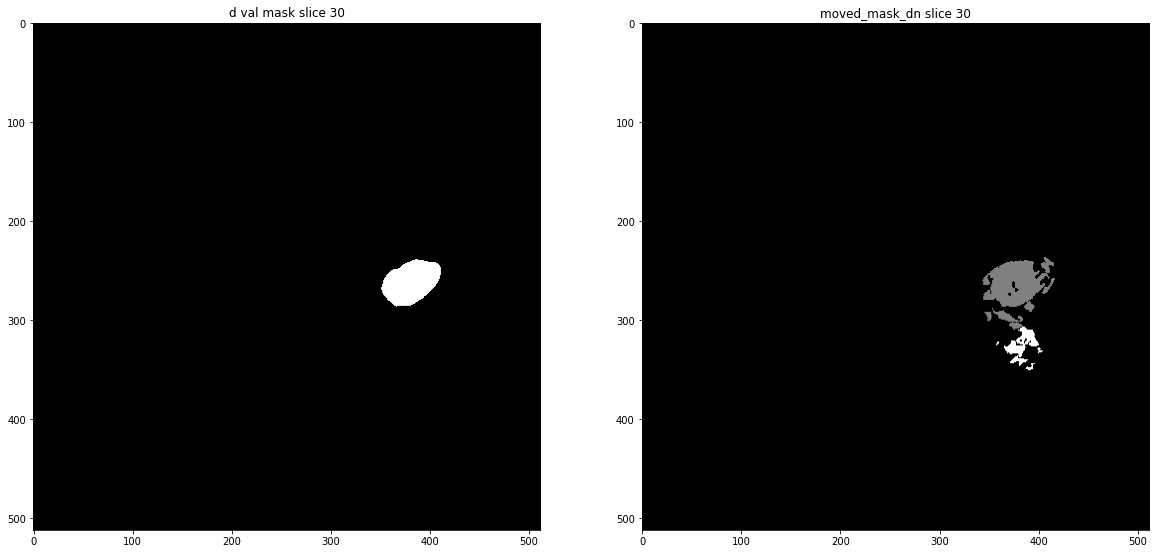

In [193]:
# visualize original mask and moved mask
slice_num = 13
fig2, (ax1, ax2) =plt.subplots(1,2, figsize = (20, 10))
ax1.set_title("d val mask slice 30")
ax1.imshow(d_mask_array[:, :, slice_num], cmap='gray')
ax2.set_title("moved_mask_dn slice 30")
ax2.imshow(moved_mask_dn[:, :, slice_num], cmap='gray')

len of labels 1
0.9336429407089732


In [69]:
print(np.max(moved_mask))

0.0


In [10]:
import torch


y_true = resized_d_scan.astype(np.float64)
y_pred = resized_d_scan.astype(np.float64)

y_true = torch.from_numpy(y_true)
y_pred = torch.from_numpy(y_pred)
d_loss = dice_loss(y_true, y_pred)
print(f"dice loss: ", d_loss.item())
print(f"dice score: ", np.mean(dice_score))

len of labels 1
dice loss:  -1685900304596.6409
dice score:  1.0


In [11]:
mse_loss =lambda src, tgt: np.mean((tgt - src) ** 2)

In [12]:
mse = mse_loss(resized_p_scan, resized_d_scan)
print(mse)

29634.853925916883


In [13]:
import torch
import torch.nn.functional as F


def NCC_loss(y_true, y_pred):

    y_true = y_true[np.newaxis, ...]
    y_pred = y_pred[np.newaxis, ...]

    y_true = y_true[np.newaxis, ...]
    y_pred = y_pred[np.newaxis, ...]

    y_true = torch.from_numpy(y_true)
    y_pred = torch.from_numpy(y_pred)


    ndims = 3
    # set window size
    win = [9, 9, 9]
    # compute filters
    sum_filt = torch.ones([1, 1, *win])

    stride = (1, 1, 1)
    padding = (4, 4, 4)

    # get convolution function
    conv_fn = getattr(F, 'conv%dd' % ndims)

    # compute CC squares
    TT = y_true * y_true
    PP = y_pred * y_pred
    TP = y_true * y_pred

    T_sum = conv_fn(y_true, sum_filt, stride=stride, padding=padding)
    P_sum = conv_fn(y_pred, sum_filt, stride=stride, padding=padding)
    TT_sum = conv_fn(TT, sum_filt, stride=stride, padding=padding)
    PP_sum = conv_fn(PP, sum_filt, stride=stride, padding=padding)
    TP_sum = conv_fn(TP, sum_filt, stride=stride, padding=padding)

    win_size = np.prod(win)
    T_hat = T_sum / win_size
    P_hat = P_sum / win_size

    cross = TP_sum - P_hat * T_sum - T_hat * P_sum + T_hat * P_hat * win_size
    T_var = TT_sum - 2 * T_hat * T_sum + T_hat * T_hat * win_size
    P_var = PP_sum - 2 * P_hat * P_sum + P_hat * P_hat * win_size

    cc = cross * cross / (T_var * P_var + 1e-5)

    return - torch.mean(cc).item()

In [14]:
def z_score(image_A, image_B):
    mean_val = np.mean(image_A)
    std_val = np.std(image_A)

    rescale_slope = std_val + 1e-13
    rescale_intercept = mean_val

    image_3d_A = (image_A - rescale_intercept) / rescale_slope

    mean_val = np.mean(image_B)
    std_val = np.std(image_B)

    rescale_slope = std_val + 1e-13
    rescale_intercept = mean_val

    image_3d_B = (image_B - rescale_intercept) / rescale_slope
    return image_3d_A, image_3d_B

In [16]:
# resized_A, resized_B = (resized_d_scan, resized_p_scan,)
resized_A, resized_B = (resized_d_scan, resized_p_scan)
print(f'check max: {np.max(resized_A)}, min: {np.min(resized_A)}')

print("cross correlation val = ", NCC_loss(resized_A.astype(np.float32), resized_B.astype(np.float32)))

check max: 3063.0, min: -1024.0
cross correlation val =  -0.6505203247070312
